# 特徴量エンジニアリング

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'

In [2]:
DATAPATH = "../../../data/"

In [3]:
with open(DATAPATH + "DBLP/keywords.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2701, 'model parameter')

In [4]:
word_dict = {}
for num, kw in enumerate(keywords):
    word_dict[kw] = num

In [5]:
N = len(keywords)
START_YEAR = 2010
END_YEAR   = 2020
YEAR_STD   = END_YEAR - START_YEAR 

In [6]:
pathes = np.load(DATAPATH+"DBLP/pathes.npy")
pathes.shape

(2701, 2701, 11)

In [7]:
pathes_s1, pathes_s2, pathes_s3 = pathes[:,:,:-5], pathes[:,:,:-6], pathes[:,:,:-7]
pathes_s1.shape, pathes_s2.shape, pathes_s3.shape

((2701, 2701, 6), (2701, 2701, 5), (2701, 2701, 4))

## 隣接行列の作成

In [8]:
pathes_sum1 = np.sum(pathes_s1, axis=2)
pathes_sum2 = np.sum(pathes_s2, axis=2)
pathes_sum3 = np.sum(pathes_s3, axis=2)
# 厳密な隣接行列ではない
adj = np.where(pathes_sum1 <= 0, 0, 1)
adj_ex2, adj_ex3 = np.where(pathes_sum2 <= 0, 0, 1), np.where(pathes_sum3 <= 0, 0, 1)
adj.shape

(2701, 2701)

## 次数の計算

In [9]:
degs1 = np.sum(adj, axis=0)
degs2 = np.sum(adj, axis=1)
degs = degs1 + degs2
degs.shape

(2701,)

In [10]:
keyword_dict = {}
for deg, kw in zip(degs, keywords):
    keyword_dict[kw] = deg

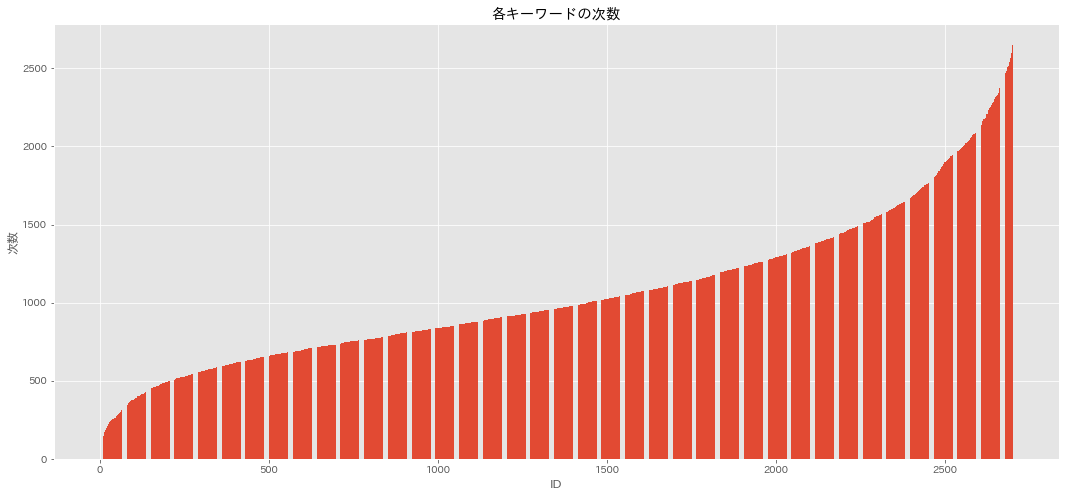

In [11]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードの次数")
ax.set_xlabel("ID")
ax.set_ylabel("次数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(degs))
# ax.bar(range(N), degs)

plt.show()

## 論文数

In [12]:
papers1 = np.sum(pathes_sum1, axis=0)
papers2 = np.sum(pathes_sum1, axis=1)
papers = papers1 + papers2
papers.shape

(2701,)

In [13]:
papers_dict = {}
for paper, kw in zip(papers, keywords):
    keyword_dict[kw] = paper

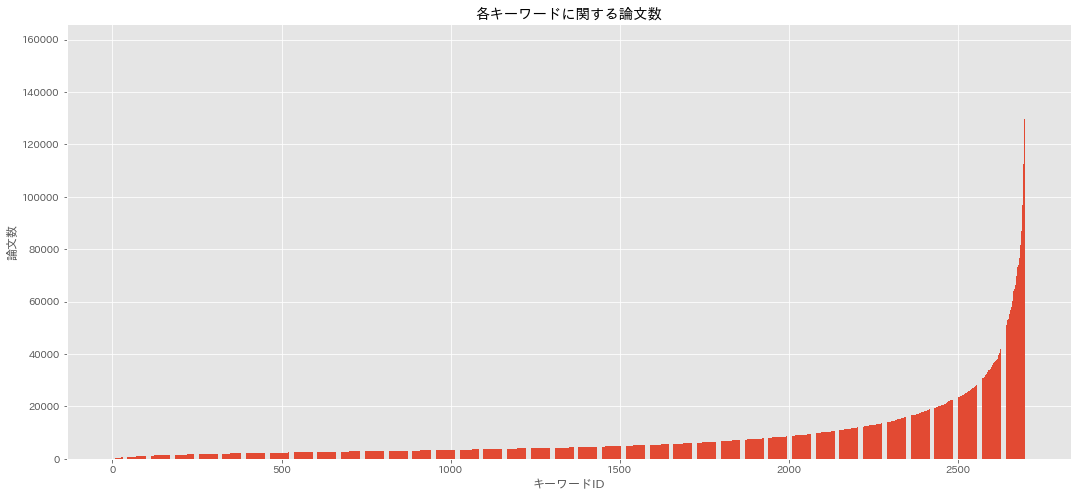

In [14]:
plt.style.use("ggplot")

# FigureとAxesを作成
fig, ax = plt.subplots(figsize=(18,8))

# タイトルと軸ラベルを設定
ax.set_title("各キーワードに関する論文数")
ax.set_xlabel("キーワードID")
ax.set_ylabel("論文数")

# Axesに棒グラフを追加
ax.bar(range(N), sorted(papers))

plt.show()

## 距離n(=2,3,4)のノード数
隣接行列の冪乗(n乗)は、距離nである各点から他の点までのルート数を表すことを利用する

In [15]:

%%time
adj = adj + adj.T
adj2 = np.linalg.matrix_power(adj, 2)
adj3 = np.linalg.matrix_power(adj, 3)
adj4 = np.linalg.matrix_power(adj, 4)

In [ ]:
adj_ex2 = adj_ex2 + adj_ex2.T
adj2_ex1 = np.linalg.matrix_power(adj_ex2, 2)
adj3_ex1 = np.linalg.matrix_power(adj_ex2, 3)
adj4_ex1 = np.linalg.matrix_power(adj_ex2, 4)

In [ ]:
adj_ex3 = adj_ex3 + adj_ex3.T
adj2_ex2 = np.linalg.matrix_power(adj_ex3, 2)
adj3_ex2 = np.linalg.matrix_power(adj_ex3, 3)
adj4_ex2 = np.linalg.matrix_power(adj_ex3, 4)

In [ ]:
adj2 = adj2 - np.max(adj2)
adj3 = adj3 - np.max(adj3)
adj4 = adj4 - np.max(adj4)

(1490, 1490)

In [ ]:
adj2_ex1 = adj2_ex1 - np.max(adj2_ex1)
adj3_ex1 = adj3_ex1 - np.max(adj3_ex1)
adj4_ex1 = adj4_ex1 - np.max(adj4_ex1)

In [ ]:
adj2_ex2 = adj2_ex2 - np.max(adj2_ex2)
adj3_ex2 = adj3_ex2 - np.max(adj_ex23)
adj4_ex2 = adj4_ex2 - np.max(adj4_ex2)

## 距離
各ノード間の距離を求める

In [ ]:
import numpy as np
from scipy.sparse.csgraph import shortest_path, floyd_warshall, dijkstra, bellman_ford, johnson
from scipy.sparse import csr_matrix

In [ ]:
%%time
distances = shortest_path(adj)
distances.shape

CPU times: user 3.11 s, sys: 24 ms, total: 3.14 s
Wall time: 3.12 s


(1490, 1490)

In [ ]:
distances

array([[0., 2., 2., ..., 2., 1., 1.],
       [2., 0., 2., ..., 1., 2., 1.],
       [2., 2., 0., ..., 2., 2., 1.],
       ...,
       [2., 1., 2., ..., 0., 1., 2.],
       [1., 2., 2., ..., 1., 0., 1.],
       [1., 1., 1., ..., 2., 1., 0.]])

In [ ]:
np.max(distances)

2.0

In [ ]:
pathes_sum = pathes_sum1 + pathes_sum1.T
distances2 = shortest_path(np.array(pathes_sum))
distances2.shape

(1490, 1490)

In [ ]:
print("グラフの密度は、{}".format(round(np.sum(adj) / len(adj) / len(adj), 3)))

グラフの密度は、0.677


とても密なグラフを用いて予測を行っている

In [ ]:
degs = degs.reshape([1,-1])
diss = degs.T.dot(degs)
diss.shape

(1490, 1490)

In [ ]:
diss_sqrt = np.sqrt(diss)
diss_sqrt.shape

(1490, 1490)

In [ ]:
distances3 = distances * diss
distances3 = distances3 / np.max(distances3)
distances4 = distances * diss_sqrt
distances4 = distances4 / np.max(distances4)

## 答え